## Stock Price Prediction
The primary focus of this project is to identify whether adding sentimental analysis to the LSTM model will provide better results in predicting stock prices. We will have two models: one that uses Long Short-Term Memory and the other that integrates sentimental analysis and LSTM to improve the accuracy of the prediction results

### LSTM without sentimental Analysis

In [1]:
#importing required libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vasay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Load Tesla stock data from the CSV file
tesla_data = pd.read_csv('tesla_stocks.csv', parse_dates=True, index_col='Date')

#Ensure the 'Date' column is sorted
tesla_data.sort_index(inplace=True)

#Filter data to only include the dates from 01-01-2016 to 12-31-2023
tesla_data = tesla_data.loc['2015-01-01':'2019-12-31']

#Rename the 'Close/Last' column to 'Close'
tesla_data.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [3]:
#Clean the data by removing the '$' sign and commas from the relevant columns
tesla_data['Close'] = tesla_data['Close'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
tesla_data['Open'] = tesla_data['Open'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
tesla_data['High'] = tesla_data['High'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
tesla_data['Low'] = tesla_data['Low'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
tesla_data['Volume'] = tesla_data['Volume'].replace({r'\$': '', r',': ''}, regex=True).astype(float)

# Use only the 'Close' column for prediction
close_data = tesla_data['Close'].values.reshape(-1, 1)

tesla_data.sort_values('Date', ascending=True, inplace=True)
print(tesla_data.head())


              Close      Volume     Open     High      Low
Date                                                      
2015-01-02  14.6207  71298549.0  14.8580  14.8833  14.2173
2015-01-05  14.0060  80332235.0  14.3033  14.4333  13.8108
2015-01-06  14.0853  93864718.0  14.0040  14.2800  13.6140
2015-01-07  14.0633  44479928.0  14.2233  14.3187  13.9853
2015-01-08  14.0410  51523489.0  14.1873  14.2533  14.0007


In [4]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Prepare data for LSTM
time_step = 60  # Number of previous days to predict the next day's stock price

X, y = [], []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i - time_step:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape the data for LSTM input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [5]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
#Build the LSTM model with Bidirectional layers
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Fix warning by using Input layer
    Bidirectional(LSTM(units=150, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=150, return_sequences=False)),
    Dropout(0.3),
    Dense(units=50),
    Dense(units=1)
])

In [7]:
# Compile the model with Adam optimizer and reduced learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - loss: 0.0436 - val_loss: 0.0121
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/ste

In [8]:
#Predict on the test set
y_pred = model.predict(X_test)

#Inverse transform to get actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step


In [9]:
#Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_actual - y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.5440397388358973
Root Mean Squared Error (RMSE): 0.7375904953535514
Mean Absolute Error (MAE): 0.5302817861874898
R² Score: 0.9553460214800789


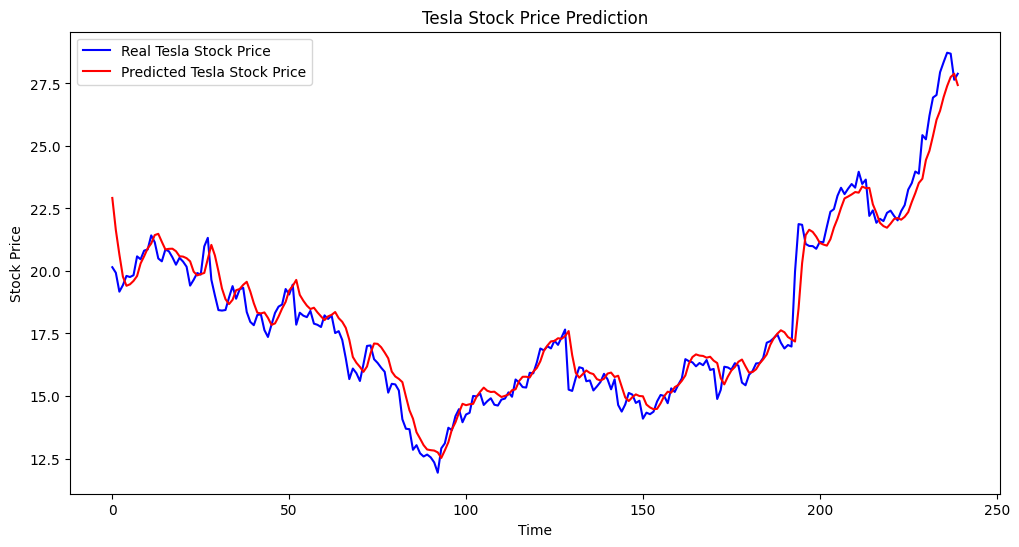

In [10]:
#Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Real Tesla Stock Price')
plt.plot(y_pred_actual, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


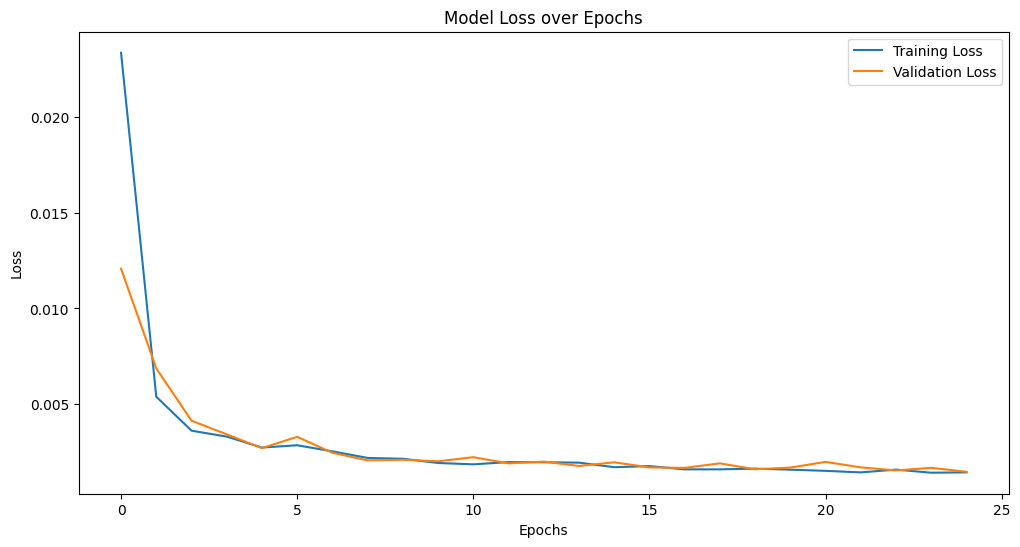

In [11]:
#Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Ensure the data is sorted by 'Date'
tesla_data.sort_values('Date', ascending=True, inplace=True)

# Align test data dates with the test set
test_start_index = len(tesla_data) - len(y_test_actual)  # Calculate start index for test data
test_dates = tesla_data.index[test_start_index:]        # Extract the corresponding dates

# Check that all lengths match
assert len(test_dates) == len(y_test_actual) == len(y_pred_actual), "Lengths do not match!"

# Create the comparison DataFrame, ensuring 1-dimensional arrays
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Close Price": y_test_actual.flatten(),  # Flatten to 1D
    "Predicted Close Price": y_pred_actual.flatten()  # Flatten to 1D
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head())


        Date  Actual Close Price  Predicted Close Price
0 2019-01-18             20.1507              22.920923
1 2019-01-22             19.9280              21.637428
2 2019-01-23             19.1727              20.659899
3 2019-01-24             19.4340              19.772213
4 2019-01-25             19.8027              19.408718


### LSTM with Sentimental analysis

In [14]:
# Load the tweets dataset
tweets = pd.read_csv('tsla_tweets_updated.csv')

# Check the initial structure of the dataset
print(tweets.head())
print(tweets.columns)

             tweet_id company_name  \
0  550442977802207232    Tesla Inc   
1  550443807834402816    Tesla Inc   
2  550443808606126081    Tesla Inc   
3  550443809700851716    Tesla Inc   
4  550443857142611968    Tesla Inc   

                                                body            post_date  \
0  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...  2015-01-01 00:06:47   
1  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01 00:10:05   
2  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01 00:10:05   
3  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01 00:10:05   
4  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01 00:10:16   

   comment_num  retweet_num  like_num  
0            0            0         1  
1            0            0         1  
2            0            0         1  
3            0            0         1  
4            0            0         1  
Index(['tweet_id', 'company_name', 'body', 'post_date', 'comment_num

In [15]:
# Ensure 'post_date' is in datetime format
tweets['post_date'] = pd.to_datetime(tweets['post_date'], errors='coerce')

# Drop rows where 'post_date' could not be converted to datetime
tweets = tweets.dropna(subset=['post_date'])

# Filter tweets by the specified date range
tweets = tweets[(tweets['post_date'] >= '2015-01-01') & (tweets['post_date'] <= '2019-12-31')]

# Check the remaining data
print(tweets['post_date'].describe())

count                          1048575
mean     2018-02-23 10:55:21.641298944
min                2015-01-01 00:06:47
25%         2017-05-01 15:56:43.500000
50%                2018-08-06 23:25:03
75%         2019-03-06 01:24:31.500000
max                2019-11-13 09:19:46
Name: post_date, dtype: object


In [16]:
# Drop unnecessary columns
tweets = tweets.drop(columns=['tweet_id', 'company_name', 'comment_num', 'retweet_num', 'like_num'])

# Check the remaining columns
print(tweets.columns)

Index(['body', 'post_date'], dtype='object')


In [17]:
# Remove the time component, keeping only the date
tweets['post_date'] = tweets['post_date'].dt.date

In [18]:
# Filter out retweets
tweets_no_retweets = tweets[~tweets['body'].str.startswith('RT')]

# Check if any rows were removed
print(f"Rows after removing retweets: {len(tweets_no_retweets)}")

# Remove duplicates
tweets_unique = tweets_no_retweets.drop_duplicates(subset='body')

# Check if any duplicates were removed
print(f"Rows after removing duplicates: {len(tweets_unique)}")

# Check if DataFrame is empty
if tweets_unique.empty:
    print("DataFrame is empty after filtering.")
else:
    print(f"Filtered tweets: {len(tweets_unique)}")

# Update the main DataFrame
tweets = tweets_unique

Rows after removing retweets: 1036477
Rows after removing duplicates: 959419
Filtered tweets: 959419


In [19]:
# Check for null values
print(tweets.isnull().sum())

# Drop rows with null values in the 'body' column
tweets = tweets.dropna(subset=['body'])

body         0
post_date    0
dtype: int64


In [20]:
# Define a text preprocessing function
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    return text.strip()

# Apply the preprocessing function
tweets['cleaned_body'] = tweets['body'].apply(preprocess_text)

In [21]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score
def get_sentiment(text):
    sentiment = vader.polarity_scores(text)
    return sentiment['compound']  # Compound score is the overall sentiment

# Apply the function to get sentiment scores
tweets['sentiment'] = tweets['cleaned_body'].apply(get_sentiment)

# Check the processed data. 
print(tweets.head())

                                                body   post_date  \
0  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...  2015-01-01   
1  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
2  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
3  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
4  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   

                                        cleaned_body  sentiment  
0  GM TSLA Volkswagen Pushes 2014 Record Recall T...        0.0  
1  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
2  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
3  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
4  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  


In [22]:
# Save the processed data to a new CSV file
tweets.to_csv('processed_tweets.csv', index=False)

In [23]:
tesla_data = pd.read_csv('tesla_stocks.csv', parse_dates=True, index_col='Date')
print(tesla_data.head()) 

           Close/Last    Volume     Open     High        Low
Date                                                        
2024-12-06    $389.22  81455830  $377.42  $389.49    $370.80
2024-12-05    $369.49  81403570  $359.87  $375.43    $359.50
2024-12-04    $357.93  50810870  $353.00  $358.10    $348.60
2024-12-03    $351.42  58267200  $351.80  $355.69    $348.20
2024-12-02    $357.09  77986480  $352.38  $360.00  $351.1501


In [24]:
tesla_data = tesla_data[(tesla_data.index >= '2015-01-01') & (tesla_data.index <= '2019-12-31')]

In [25]:
tesla_data = tesla_data.loc[~tesla_data.index.duplicated(keep='first')]

In [26]:
print(tesla_data.isnull().sum())  

# Fill missing values with forward fill or drop rows with missing values
tesla_data.fillna(method='ffill', inplace=True)  

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


C:\Users\vasay\AppData\Local\Temp\ipykernel_10984\884598999.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tesla_data.fillna(method='ffill', inplace=True)


In [27]:
# Remove non-numeric characters (like '$') and commas from 'Close/Last', 'Open', 'High', 'Low'
tesla_data['Close/Last'] = tesla_data['Close/Last'].replace(r'[\$,]', '', regex=True).astype(float)
tesla_data['Open'] = tesla_data['Open'].replace(r'[\$,]', '', regex=True).astype(float)
tesla_data['High'] = tesla_data['High'].replace(r'[\$,]', '', regex=True).astype(float)
tesla_data['Low'] = tesla_data['Low'].replace(r'[\$,]', '', regex=True).astype(float)

# Verify data types after conversion
print(tesla_data.dtypes)

Close/Last    float64
Volume          int64
Open          float64
High          float64
Low           float64
dtype: object


In [28]:
print(tesla_data.index)

DatetimeIndex(['2019-12-31', '2019-12-30', '2019-12-27', '2019-12-26',
               '2019-12-24', '2019-12-23', '2019-12-20', '2019-12-19',
               '2019-12-18', '2019-12-17',
               ...
               '2015-01-15', '2015-01-14', '2015-01-13', '2015-01-12',
               '2015-01-09', '2015-01-08', '2015-01-07', '2015-01-06',
               '2015-01-05', '2015-01-02'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)


In [29]:
tesla_data.reset_index(inplace=True)

In [30]:
tesla_data.set_index('Date', inplace=True)
print(tesla_data.columns)

Index(['Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')


In [31]:
# Sort the data by the index (Date) in ascending order (2016 to 2023)
tesla_data = tesla_data.sort_index()

# Filter the data between 01-01-2016 and 12-31-2023
tesla_data = tesla_data.loc['2015-01-01':'2019-12-31']

In [32]:
# Read the CSV file into sentiment_data
sentiment_data = pd.read_csv('processed_tweets.csv')

# Convert 'Date' and 'post_date' from index to column in both datasets
tesla_data = tesla_data.reset_index()  # This makes 'Date' a column
sentiment_data = sentiment_data.reset_index()  # This makes 'post_date' a column

# Now, 'Date' or 'post_date' will be regular columns in both datasets.
print(tesla_data.head()) 
print(sentiment_data.head()) 

        Date  Close/Last    Volume     Open     High      Low
0 2015-01-02     14.6207  71298549  14.8580  14.8833  14.2173
1 2015-01-05     14.0060  80332235  14.3033  14.4333  13.8108
2 2015-01-06     14.0853  93864718  14.0040  14.2800  13.6140
3 2015-01-07     14.0633  44479928  14.2233  14.3187  13.9853
4 2015-01-08     14.0410  51523489  14.1873  14.2533  14.0007
   index                                               body   post_date  \
0      0  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...  2015-01-01   
1      1  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
2      2  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
3      3  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
4      4  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   

                                        cleaned_body  sentiment  
0  GM TSLA Volkswagen Pushes 2014 Record Recall T...        0.0  
1  Swing Trading Up To 891 Return In 14 Days 

In [33]:
# Rename 'post_date' to 'Date' in the sentiment data
sentiment_data = sentiment_data.rename(columns={'post_date': 'Date'})

# Check the first few rows to confirm the change
print(sentiment_data.head())

   index                                               body        Date  \
0      0  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...  2015-01-01   
1      1  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
2      2  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
3      3  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   
4      4  Swing Trading: Up To 8.91% Return In 14 Days h...  2015-01-01   

                                        cleaned_body  sentiment  
0  GM TSLA Volkswagen Pushes 2014 Record Recall T...        0.0  
1  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
2  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
3  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  
4  Swing Trading Up To 891 Return In 14 Days  swi...        0.0  


In [34]:
# Display some sample dates from both datasets
print(tesla_data['Date'].head())
print(sentiment_data['Date'].head())

0   2015-01-02
1   2015-01-05
2   2015-01-06
3   2015-01-07
4   2015-01-08
Name: Date, dtype: datetime64[ns]
0    2015-01-01
1    2015-01-01
2    2015-01-01
3    2015-01-01
4    2015-01-01
Name: Date, dtype: object


In [35]:
# Convert the Date columns to datetime format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])

# Display the first few dates again
print(tesla_data['Date'].head())
print(sentiment_data['Date'].head())

0   2015-01-02
1   2015-01-05
2   2015-01-06
3   2015-01-07
4   2015-01-08
Name: Date, dtype: datetime64[ns]
0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: Date, dtype: datetime64[ns]


In [36]:
# Replace the original sentiment data with the grouped data (if you're keeping only one row per date)
sentiment_data_updated = sentiment_data.groupby('Date').agg({'sentiment': 'mean'}).reset_index()

print("Sentiment Date Range: ", sentiment_data_updated['Date'].min(), sentiment_data_updated['Date'].max())

# Save the updated sentiment data to a new CSV file
sentiment_data_updated.to_csv('updated_tweet_data.csv', index=False)

# Print the head of the updated sentiment data
print(sentiment_data_updated.head())

Sentiment Date Range:  2015-01-01 00:00:00 2019-11-13 00:00:00
        Date  sentiment
0 2015-01-01   0.136994
1 2015-01-02   0.114938
2 2015-01-03   0.044762
3 2015-01-04   0.089517
4 2015-01-05   0.126213


In [37]:
print(sentiment_data_updated.dtypes)

Date         datetime64[ns]
sentiment           float64
dtype: object


In [38]:
updated_sentiment = pd.read_csv('updated_tweet_data.csv', dtype={'Date': str})
print(updated_sentiment.head())

         Date  sentiment
0  2015-01-01   0.136994
1  2015-01-02   0.114938
2  2015-01-03   0.044762
3  2015-01-04   0.089517
4  2015-01-05   0.126213


In [39]:
# Check the data types of each column
print(updated_sentiment.dtypes)

# Check the column names
print(updated_sentiment.columns)

Date          object
sentiment    float64
dtype: object
Index(['Date', 'sentiment'], dtype='object')


In [40]:
updated_sentiment['Date'] = pd.to_datetime(updated_sentiment['Date'])

In [41]:
print(updated_sentiment['Date'].head())

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: Date, dtype: datetime64[ns]


In [42]:

print(tesla_data['Date'].head())

0   2015-01-02
1   2015-01-05
2   2015-01-06
3   2015-01-07
4   2015-01-08
Name: Date, dtype: datetime64[ns]


In [43]:
# Ensure Date columns are of the same datetime format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'], format='%Y-%m-%d')
updated_sentiment['Date'] = pd.to_datetime(updated_sentiment['Date'], format='%Y-%m-%d')

# Check for missing or NaN values in the Date column
print(tesla_data['Date'].isnull().sum())  # Check for missing values in tesla_data
print(updated_sentiment['Date'].isnull().sum())  # Check for missing values in updated_sentiment

# Drop rows with NaN values in the Date column (if any)
tesla_data = tesla_data.dropna(subset=['Date'])
updated_sentiment = updated_sentiment.dropna(subset=['Date'])

# Check the range of dates to ensure overlap
print("Tesla Date Range: ", tesla_data['Date'].min(), tesla_data['Date'].max())
print("Sentiment Date Range: ", updated_sentiment['Date'].min(), updated_sentiment['Date'].max())

# Merge the datasets on 'Date' using an inner join (only matching dates)
merged_data = pd.merge(tesla_data, updated_sentiment, on='Date', how='inner')

merged_data.to_csv('merged_data_with_sentiments.csv', index=False)

# Optionally, print the first few rows of the merged dataset for inspection
print(merged_data.head())

0
0
Tesla Date Range:  2015-01-02 00:00:00 2019-12-31 00:00:00
Sentiment Date Range:  2015-01-01 00:00:00 2019-11-13 00:00:00
        Date  Close/Last    Volume     Open     High      Low  sentiment
0 2015-01-02     14.6207  71298549  14.8580  14.8833  14.2173   0.114938
1 2015-01-05     14.0060  80332235  14.3033  14.4333  13.8108   0.126213
2 2015-01-06     14.0853  93864718  14.0040  14.2800  13.6140   0.094870
3 2015-01-07     14.0633  44479928  14.2233  14.3187  13.9853   0.062664
4 2015-01-08     14.0410  51523489  14.1873  14.2533  14.0007   0.096713


In [44]:
# Ensure 'Date' is the index (if it isn't already)
merged_data.set_index('Date', inplace=True)

# Define target and feature columns
target_column = 'Close/Last'
features_columns = ['sentiment', 'Volume', 'Open', 'High', 'Low']

correlation = merged_data[['sentiment', 'Close/Last']].corr()
print(correlation)

            sentiment  Close/Last
sentiment    1.000000    0.257602
Close/Last   0.257602    1.000000


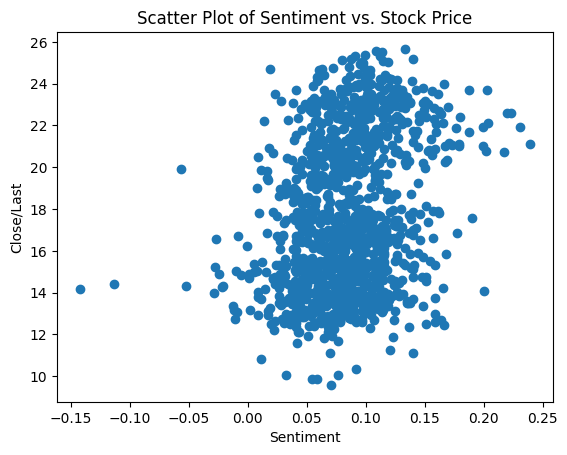

In [45]:
plt.scatter(merged_data['sentiment'], merged_data['Close/Last'])
plt.xlabel('Sentiment')
plt.ylabel('Close/Last')
plt.title('Scatter Plot of Sentiment vs. Stock Price')
plt.show()


In [46]:
# Initialize separate scalers for features and target
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale features and target separately
scaled_features = feature_scaler.fit_transform(merged_data[features_columns])
scaled_target = target_scaler.fit_transform(merged_data[[target_column]])

# Prepare the data for LSTM
time_step = 60  # Use 60 days to predict the next day's price

X, y = [], []
for i in range(time_step, len(scaled_features)):
    X.append(scaled_features[i - time_step:i, :])  # Input sequence (features for 60 days)
    y.append(scaled_target[i, 0])  # Output (target value, 'Close/Last' price)

X, y = np.array(X), np.array(y)

# Reshape X for LSTM input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [47]:
# Split into training and test sets (using time series split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shape of the data to confirm
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (932, 60, 5)
X_test shape: (234, 60, 5)
y_train shape: (932,)
y_test shape: (234,)


In [48]:
# Build the LSTM model with Bidirectional layers
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Fix warning by using Input layer
    Bidirectional(LSTM(units=150, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=150, return_sequences=False)),
    Dropout(0.3),
    Dense(units=50),
    Dense(units=1)
])


In [49]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.0645 - val_loss: 0.0073
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0046 - val_loss: 0.0110
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0032 - val_loss: 0.0067
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/ste

In [50]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_pred_actual = target_scaler.inverse_transform(y_pred)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Ensure the predictions and actual values are flattened
y_test_actual = y_test_actual.flatten()
y_pred_actual = y_pred_actual.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step


In [51]:
# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_actual - y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 0.7147869212027042
Root Mean Squared Error (RMSE): 0.8454507207417261
Mean Absolute Error (MAE): 0.6464665815500114
R² Score: 0.9150983199377484


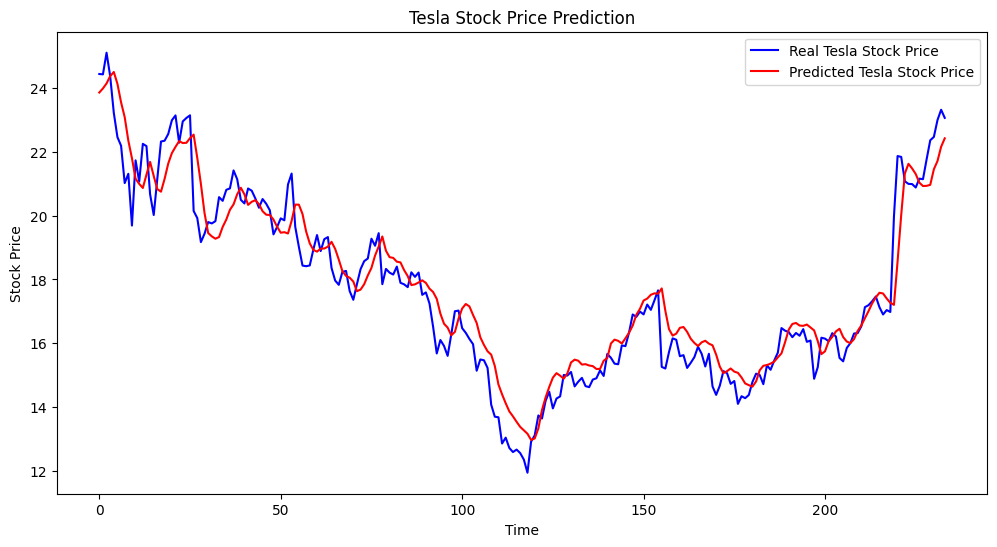

In [52]:
# Plot predicted vs actual stock price
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Real Tesla Stock Price')
plt.plot(y_pred_actual, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


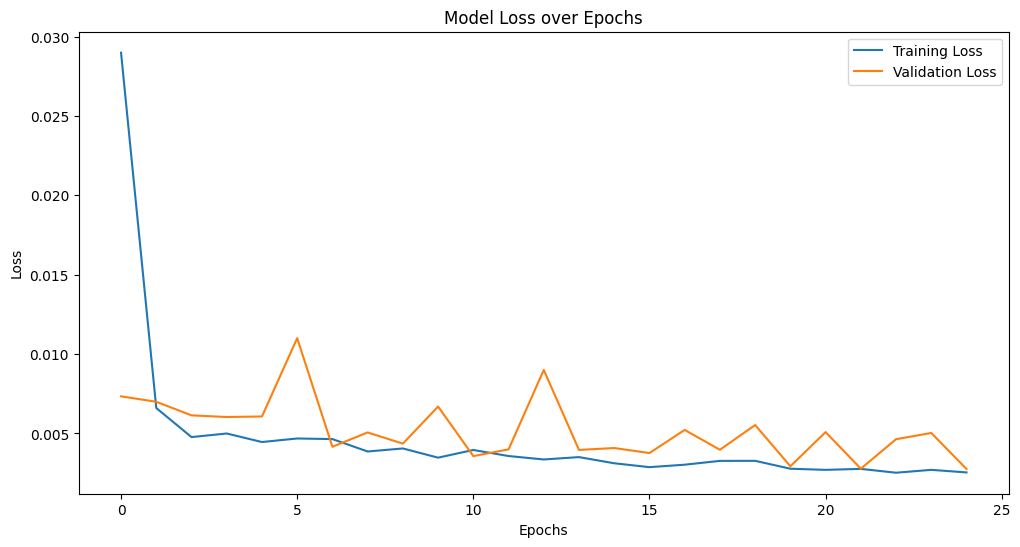

In [53]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [54]:
# Ensure the data is sorted by 'Date'
merged_data.sort_values('Date', ascending=True, inplace=True)

# Align test data dates with the test set
test_start_index = len(merged_data) - len(y_test_actual)  # Calculate start index for test data
test_dates = merged_data.index[test_start_index:]        # Extract the corresponding dates

# Check that all lengths match
assert len(test_dates) == len(y_test_actual) == len(y_pred_actual), "Lengths do not match!"

# Create the comparison DataFrame, ensuring 1-dimensional arrays
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Close Price": y_test_actual.flatten(),  # Flatten to 1D
    "Predicted Close Price": y_pred_actual.flatten()  # Flatten to 1D
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head())


        Date  Actual Close Price  Predicted Close Price
0 2018-12-11             24.4507              23.869783
1 2018-12-12             24.4400              23.997629
2 2018-12-13             25.1193              24.155029
3 2018-12-14             24.3807              24.385111
4 2018-12-17             23.2280              24.514244


### LSTM without sentimental analysis on merged data

In [55]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Load Tesla stock data from the CSV file
tesla_data = pd.read_csv('merged_data_with_sentiments.csv', parse_dates=True, index_col='Date')

#Ensure the 'Date' column is sorted
tesla_data.sort_index(inplace=True)

#Filter data to only include the dates from 01-01-2016 to 12-31-2023
tesla_data = tesla_data.loc['2015-01-01':'2019-12-31']

#Rename the 'Close/Last' column to 'Close'
tesla_data.rename(columns={'Close/Last': 'Close'}, inplace=True)

print(tesla_data.head())

              Close    Volume     Open     High      Low  sentiment
Date                                                               
2015-01-02  14.6207  71298549  14.8580  14.8833  14.2173   0.114938
2015-01-05  14.0060  80332235  14.3033  14.4333  13.8108   0.126213
2015-01-06  14.0853  93864718  14.0040  14.2800  13.6140   0.094870
2015-01-07  14.0633  44479928  14.2233  14.3187  13.9853   0.062664
2015-01-08  14.0410  51523489  14.1873  14.2533  14.0007   0.096713


In [56]:
# Define target and feature columns note that we are removing sentiment from the feature columns
target_column = 'Close'
features_columns = ['Volume', 'Open', 'High', 'Low']

In [57]:
# Initialize separate scalers for features and target
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale features and target separately
scaled_features = feature_scaler.fit_transform(tesla_data[features_columns])
scaled_target = target_scaler.fit_transform(tesla_data[[target_column]])

# Prepare the data for LSTM
time_step = 60  # Use 60 days to predict the next day's price

X, y = [], []
for i in range(time_step, len(scaled_features)):
    X.append(scaled_features[i - time_step:i, :])  # Input sequence (features for 60 days)
    y.append(scaled_target[i, 0])  # Output (target value, 'Close/Last' price)

X, y = np.array(X), np.array(y)

# Reshape X for LSTM input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [58]:
# Split into training and test sets (using time series split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shape of the data to confirm
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (932, 60, 4)
X_test shape: (234, 60, 4)
y_train shape: (932,)
y_test shape: (234,)


In [59]:
# Build the LSTM model with Bidirectional layers
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Fix warning by using Input layer
    Bidirectional(LSTM(units=150, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=150, return_sequences=False)),
    Dropout(0.3),
    Dense(units=50),
    Dense(units=1)
])


In [60]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 307ms/step - loss: 0.0709 - val_loss: 0.0075
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 0.0052 - val_loss: 0.0068
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.0045 - val_loss: 0.0104
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - loss: 0.0036 - val_loss: 0.0080
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/ste

In [61]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_pred_actual = target_scaler.inverse_transform(y_pred)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Ensure the predictions and actual values are flattened
y_test_actual = y_test_actual.flatten()
y_pred_actual = y_pred_actual.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step


In [62]:
# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_actual - y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 0.7665266653211846
Root Mean Squared Error (RMSE): 0.8755150857187926
Mean Absolute Error (MAE): 0.6633533590007034
R² Score: 0.9089527245563183


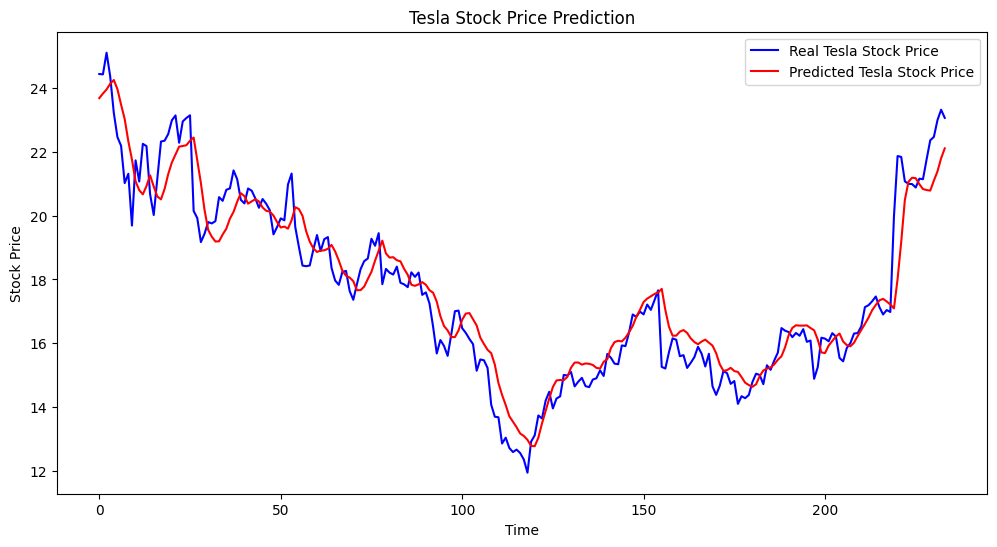

In [63]:
# Plot predicted vs actual stock price
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Real Tesla Stock Price')
plt.plot(y_pred_actual, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


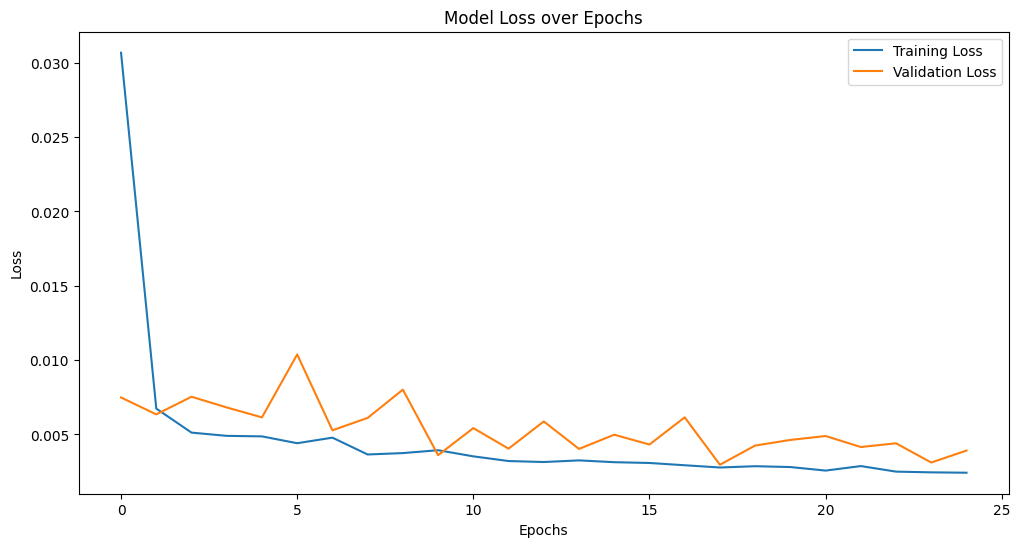

In [64]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
# Ensure the data is sorted by 'Date'
tesla_data.sort_values('Date', ascending=True, inplace=True)

# Align test data dates with the test set
test_start_index = len(tesla_data) - len(y_test_actual)  # Calculate start index for test data
test_dates = tesla_data.index[test_start_index:]        # Extract the corresponding dates

# Check that all lengths match
assert len(test_dates) == len(y_test_actual) == len(y_pred_actual), "Lengths do not match!"

# Create the comparison DataFrame, ensuring 1-dimensional arrays
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Close Price": y_test_actual.flatten(),  # Flatten to 1D
    "Predicted Close Price": y_pred_actual.flatten()  # Flatten to 1D
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head())


        Date  Actual Close Price  Predicted Close Price
0 2018-12-11             24.4507              23.694239
1 2018-12-12             24.4400              23.837360
2 2018-12-13             25.1193              23.965725
3 2018-12-14             24.3807              24.143629
4 2018-12-17             23.2280              24.263414
